# Serpens bis

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Serpens/'
name = 'serpens_bis'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = path + 'HGBS_serpens_column_density_map.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

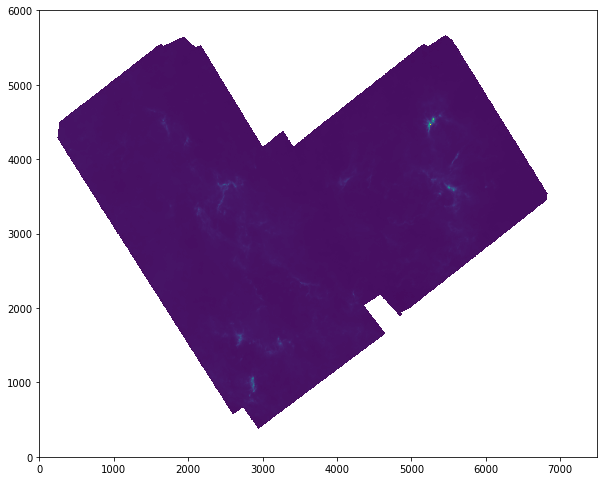

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

INFO: Auto-setting vmin to -6.443e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.757e+22 [aplpy.core]


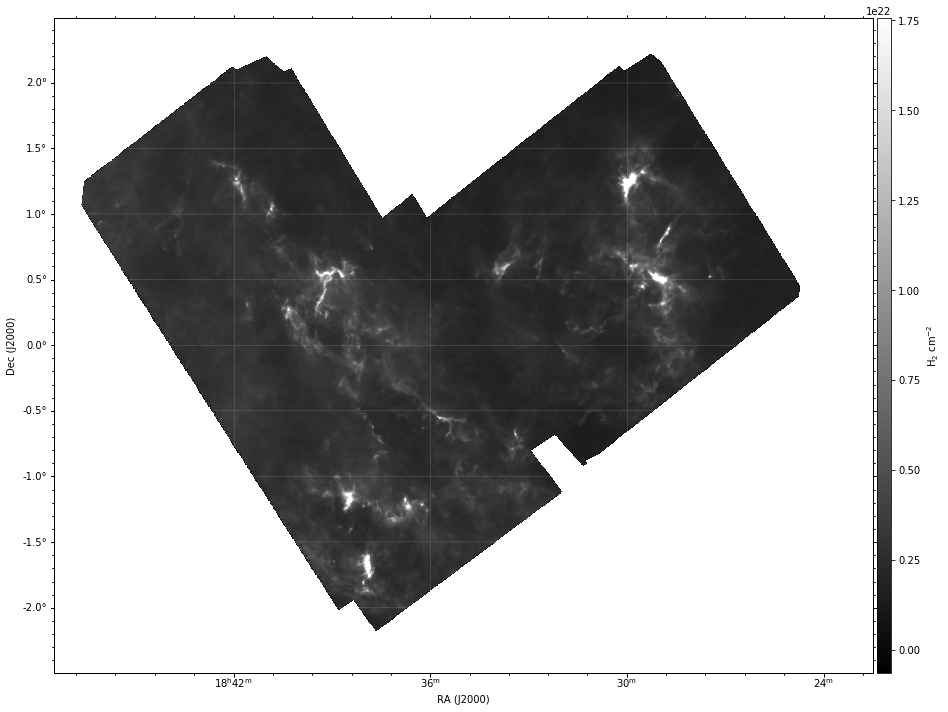

In [5]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_serpens_column_density_map.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [6]:
header

SIMPLE  =                    T / Written by IDL:  Fri Sep 29 17:30:22 2017      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 7500                                                  
NAXIS2  =                 6000                                                  
COMMENT Science data image                                                      
CREATOR = 'IDL               '                                                  
TELESCOP= 'Herschel Space Observatory'                                          
INSTRUME= 'SPIRE/PACS'                                                          
PROPOSAL= 'KPGT_pandre_1'                                                       
PRTITLE = 'Herschel Gould Belt Survey (HGBS)'                                   
COMMENT Reference publication of the survey: Andre' et al. (2010)               
COMMENT bibcode: 2010A&A...5

In [5]:
import reproject as proj

In [8]:
hdproj = header.copy()

ratio = 0.00388889/0.00083333333333333

#Change pixel resolution
hdproj['CDELT1'] = -0.00388889
hdproj['CDELT2'] = 0.00388889
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(header['NAXIS1']/ratio)
hdproj['NAXIS2'] = np.int(header['NAXIS2']/ratio)
#Rotate the map
hdproj['CROTA1'] = -38.3057
hdproj['CROTA2'] = -38.3057


improj = proj.reproject_exact(HDU,hdproj)
improjnp = np.asarray(improj)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',improjnp[0,:,:], hdproj, overwrite=True)

In [6]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to  1.909e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.463e+22 [aplpy.core]


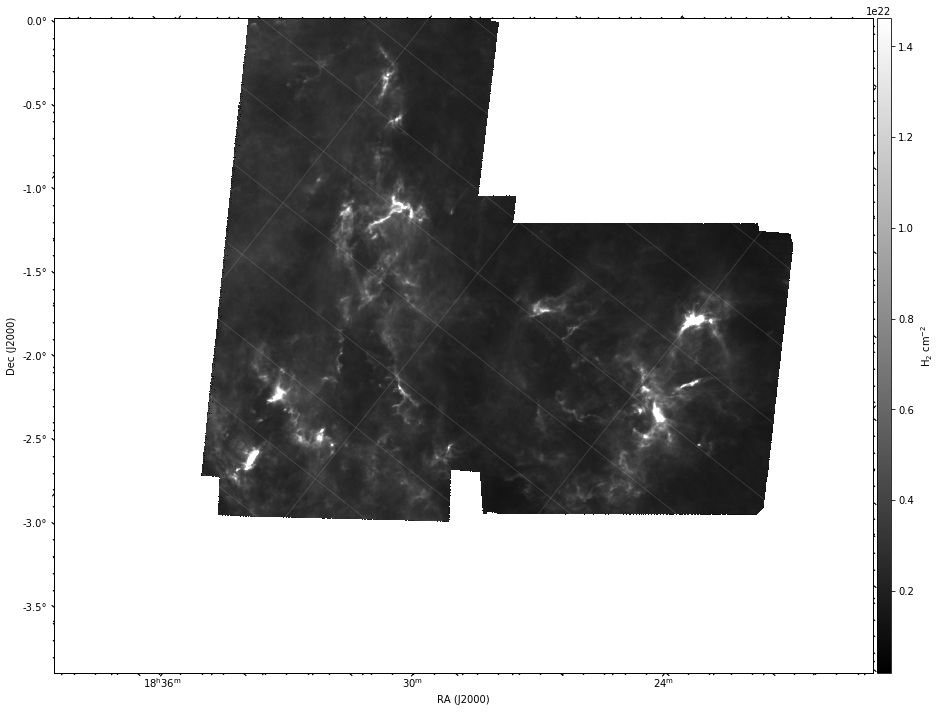

In [10]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [7]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits')
im = HDU[0].data
header = HDU[0].header

In [8]:
#Cut the map
input = path + 'HGBS_' + name + '_column_density_map_rebin_rot.fits'
output = path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits'
coords = np.array([879,311,1379,878])
subfits(input,output,coords)

Dimensions 501 568


In [2]:
#Read map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to -1.726e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.883e+22 [aplpy.core]


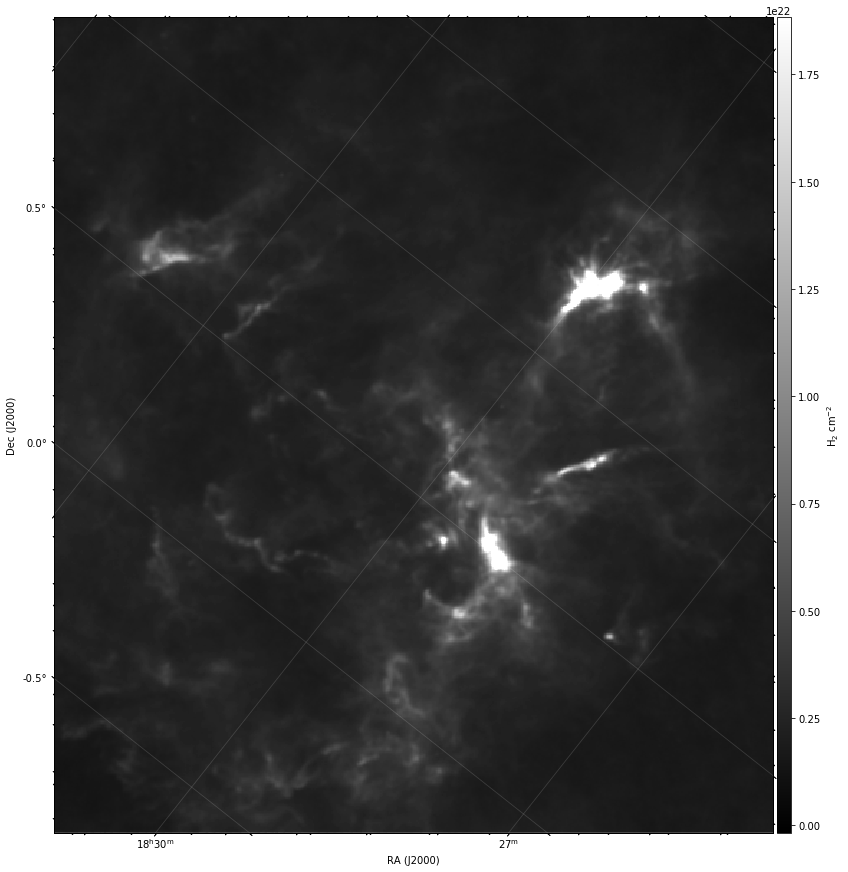

In [3]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

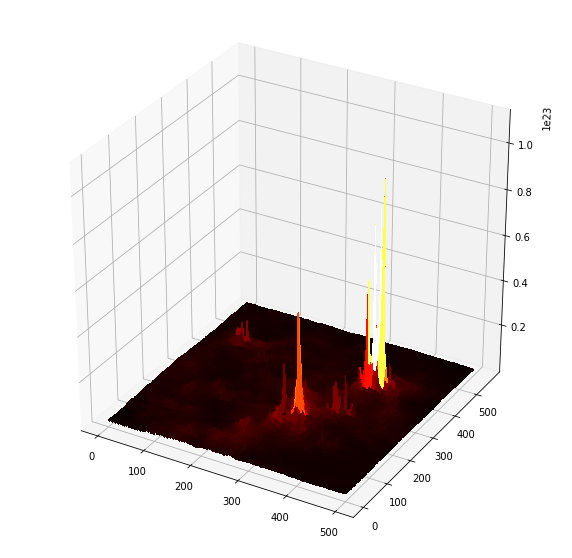

In [4]:
from mpl_toolkits.mplot3d import Axes3D
dim2=im.shape[0]
dim1=im.shape[1]
X=np.linspace(0,dim1-1,dim1)
Y=np.linspace(0,dim2-1,dim2)
X,Y=np.meshgrid(X,Y)
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
#ax.set_zlim([-0.3,0.3])
ax.plot_surface(X,Y,im,cmap='hot',antialiased=False)
#ax.view_init(45,45)

In [11]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im #- meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((700,600))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

In [12]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

600 700


Text(0.5, 1.0, 'Beam power spectrum')

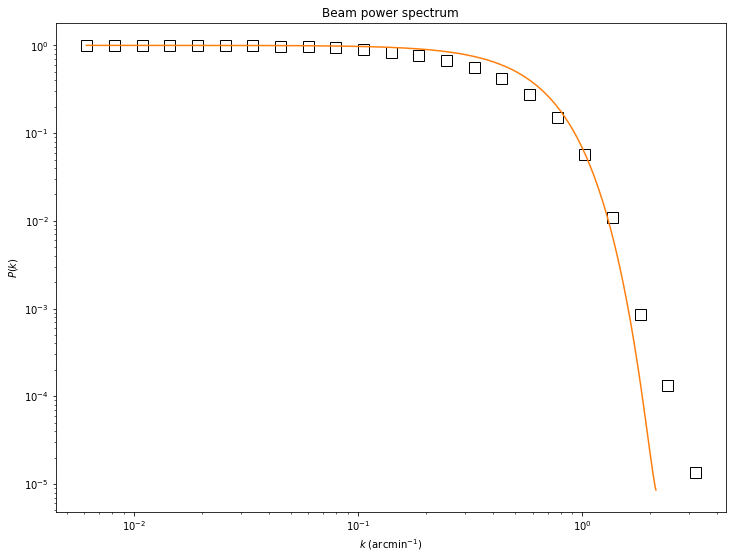

In [13]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[4]
BS1an[:4] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
Coherent wavelet
A, Gamma, P0 =  2.02048e+42 -2.14347 1.55622e+42
Gaussian wavelet
A, Gamma, P0 =  9.874626759390036e+38 -3.7368793958655195 0.0


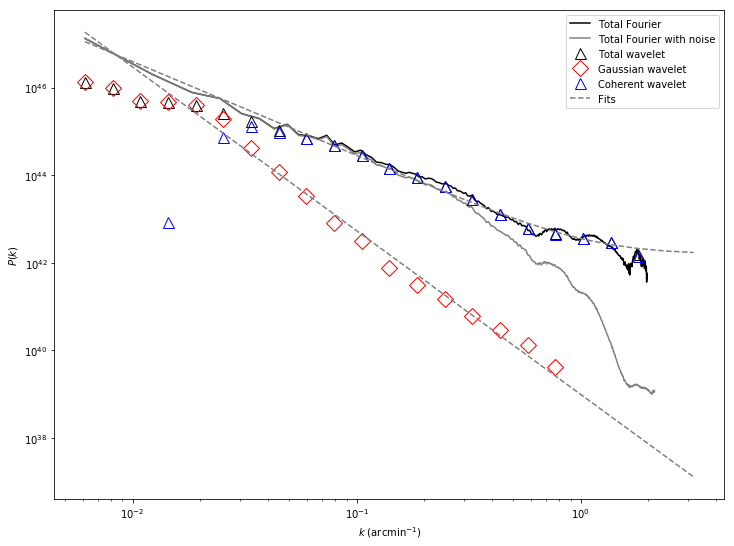

In [14]:
Noise = spec_k[-1]

#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[5:17]), np.log(S1a[2,5:17]/BS1an[5:17]),deg=1,cov=True)
fit_gauss = np.exp(A[1])*wav_k**A[0]
A_cohe, gamma_cohe, P0_cohe = 20.2048e+41,  -2.14347, 15.5622e+41
fit_cohe=A_cohe*wav_k**gamma_cohe+P0_cohe

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', A_cohe, gamma_cohe, P0_cohe)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', np.exp(A[1]), A[0], 0.)

plt.figure(figsize(12,9))
plt.plot(tab_k[:-25], (spec_k[:-25]-Noise)/spec_beamn2[:-25], color='black',label=r'Total Fourier')
plt.plot(tab_k, spec_k, color='grey',label=r'Total Fourier with noise')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')

plt.plot(wav_k, fit_gauss, color='grey', ls='--', lw=1.5, label=r'Fits')
plt.plot(wav_k, fit_cohe, color='grey', ls='--', lw=1.5)
"""
x1=1.12
plt.plot([x1,x1],[1e38,1e44], ls=':', label=np.str(x1)+' arcmin$^{-1}$')
x2=0.77
plt.plot([x2,x2],[1e38,1e44], ls=':', label=np.str(x2)+' arcmin$^{-1}$')
"""
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

plt.savefig(path + 'HGBS_' + name + '_column_density_map_power_spec.png', dpi=500)

Text(0.5, 1.0, 'k=0.7690521996909329')

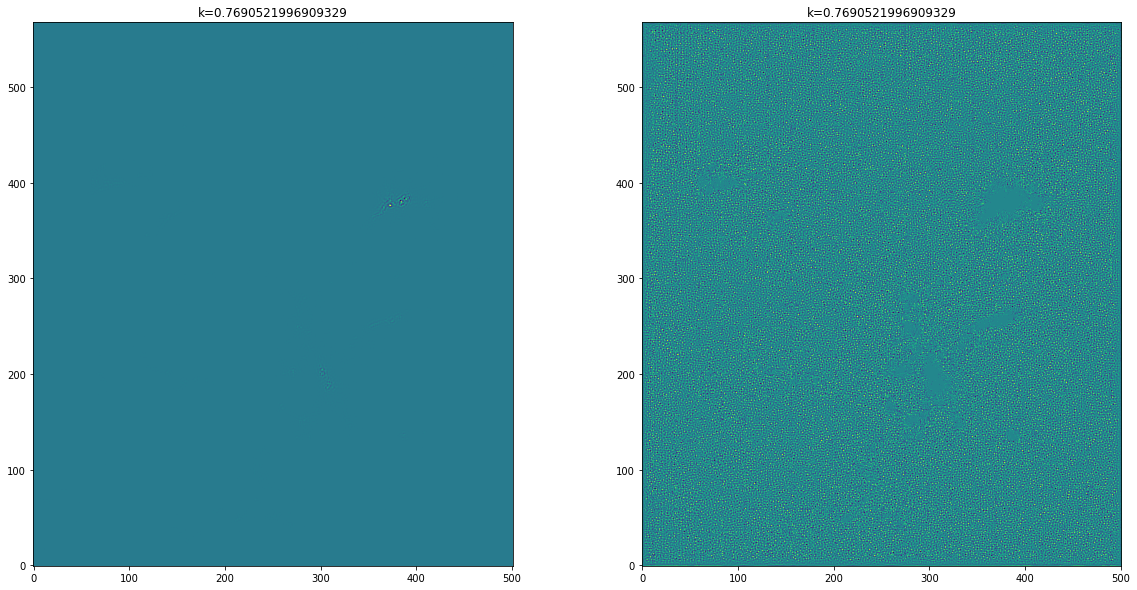

In [15]:
M=np.size(wav_k)
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(S11a[M+17,:,:], origin='bottom')
imshow(wt[M+20,:,:].real, origin='bottom')
plt.title('k='+np.str(wav_k[17]))

plt.subplot(1,2,2)
imshow(S11a[2*M+17,:,:], origin='bottom')
imshow(wt[2*M+20,:,:].real, origin='bottom')
plt.title('k='+np.str(wav_k[17]))

In [16]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M+5,:,:].real,axis=0)
scale_free = np.sum(wt[2*M+5:3*M,:,:].real,axis=0)

fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits', filaments, header, overwrite=True)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits', scale_free, header, overwrite=True)

INFO: Auto-setting vmin to -3.235e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.136e+22 [aplpy.core]
INFO: Auto-setting vmin to -1.097e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.584e+21 [aplpy.core]


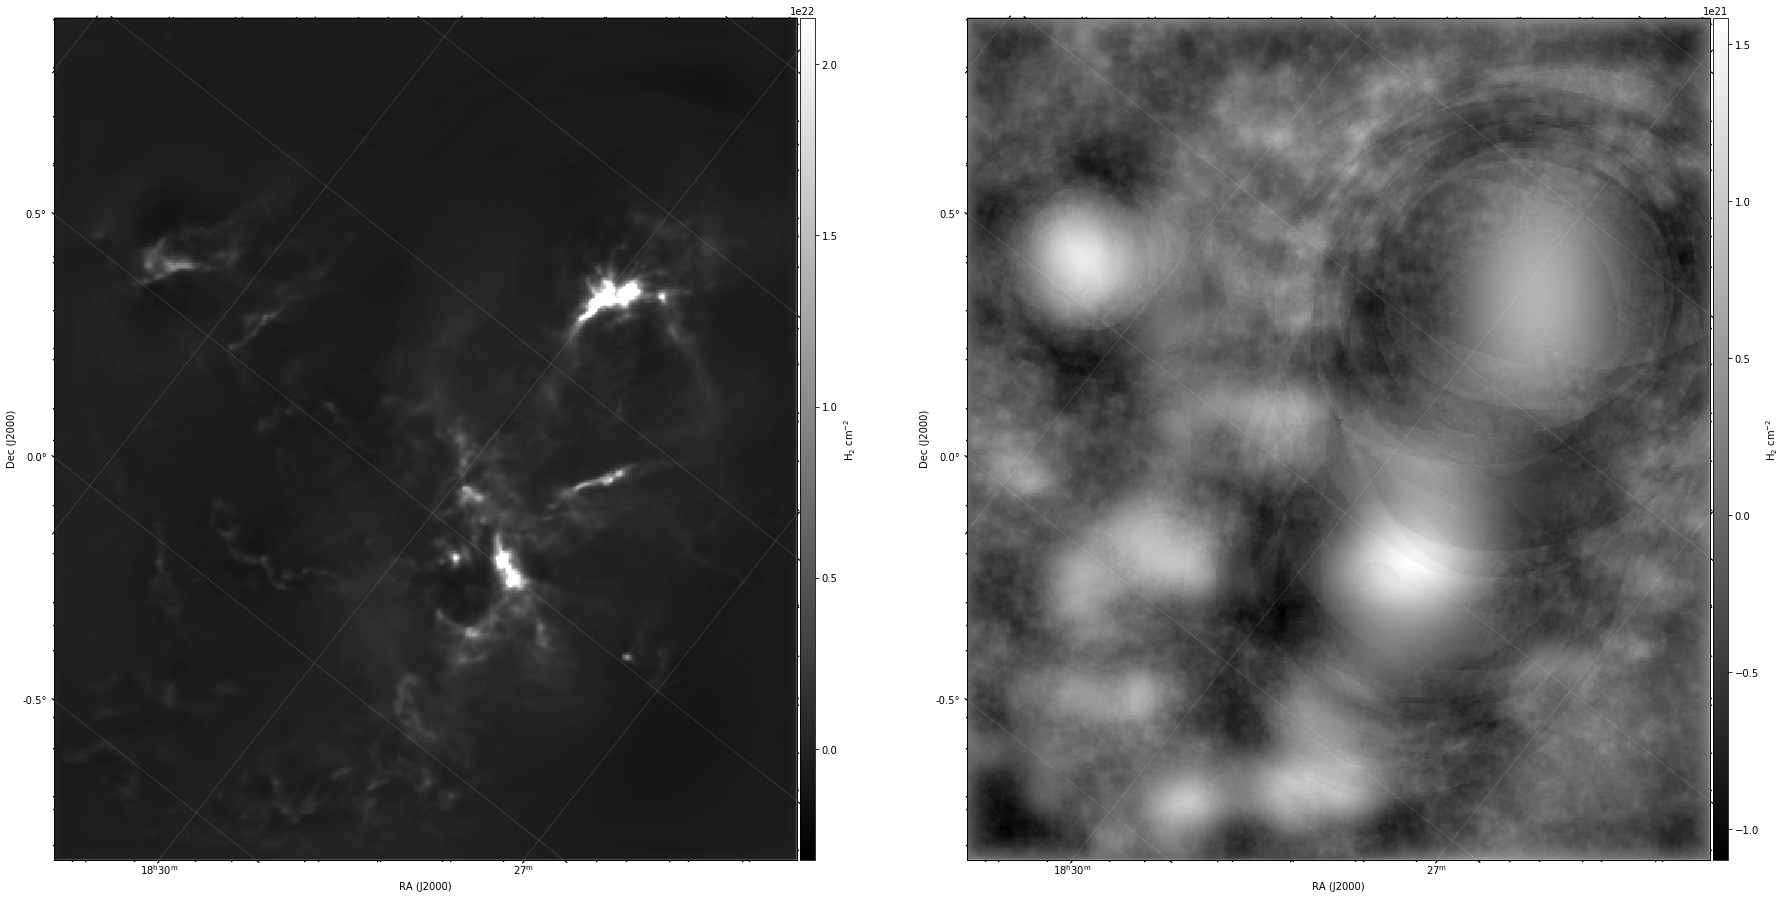

In [17]:
fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits',figure=fig_all, subplot=(1,2,1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits',figure=fig_all, subplot=(1,2,2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')